In [2]:
#publish to git
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

Data ingestion and cleaning

In [3]:
df= pd.read_csv("project_adult.csv")
df_val = pd.read_csv("project_validation_inputs.csv")

In [4]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
4,9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [5]:
df_val.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
1,27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
4,7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


In [6]:

# Identifying missing values 
cols_with_question_mark = df.columns[df.isin(['?']).any()]
print("Columns with '?' values:")
print(cols_with_question_mark)


Columns with '?' values:
Index(['workclass', 'occupation', 'native-country'], dtype='object')


In [7]:
question_mark_counts = (df == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         1447
occupation        1454
native-country     458
dtype: int64


In [8]:
cols_with_question_mark = df_val.columns[df_val.isin(['?']).any()]
question_mark_counts = (df_val == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         389
occupation        389
native-country    125
dtype: int64


Imputing missing values with the mode and Scaling data

In [9]:

# Replace '?' with NaN
df = df.replace('?', np.nan)

df_val = df_val.replace('?', np.nan)

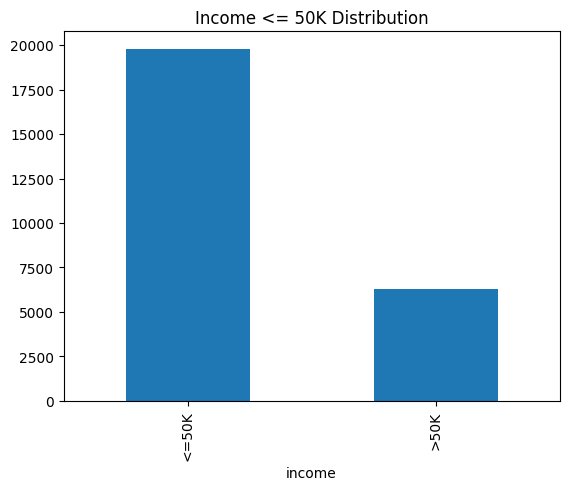

In [10]:
df['income'].value_counts().plot(kind='bar')
plt.title('Income <= 50K Distribution')
plt.show()


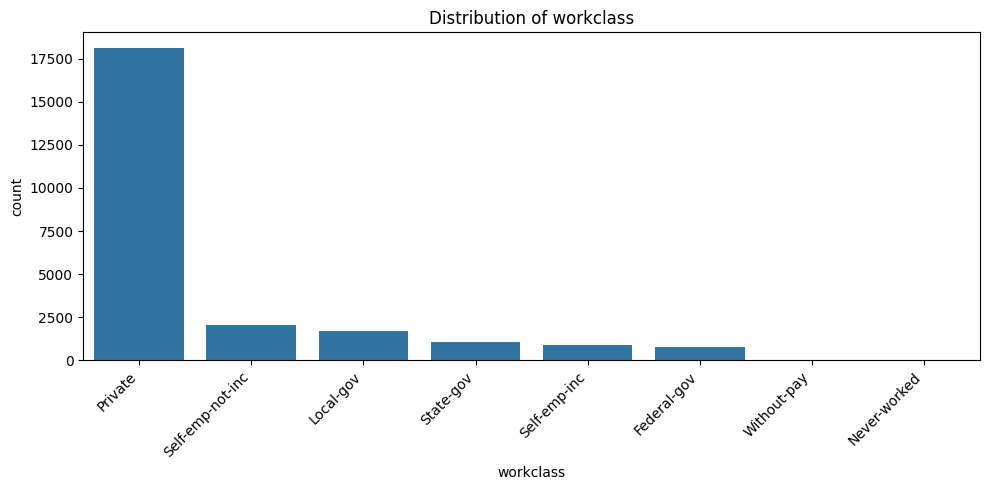

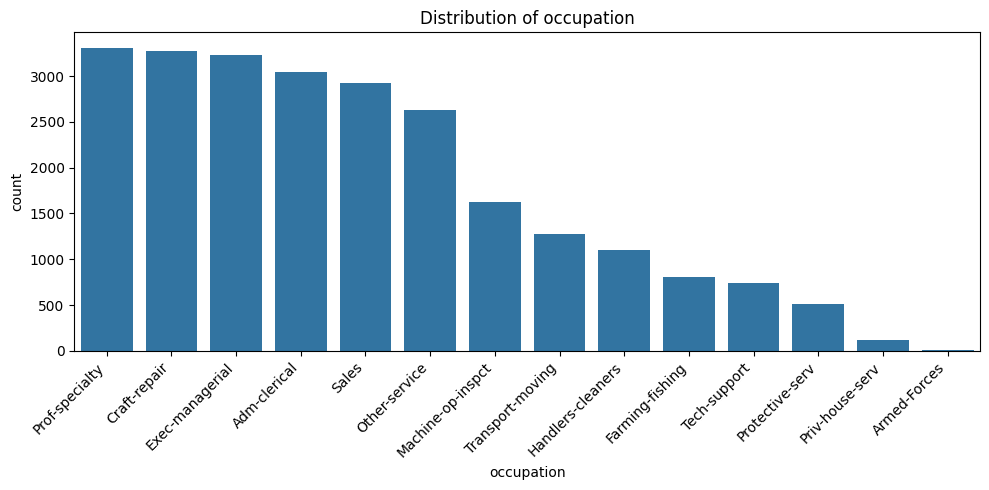

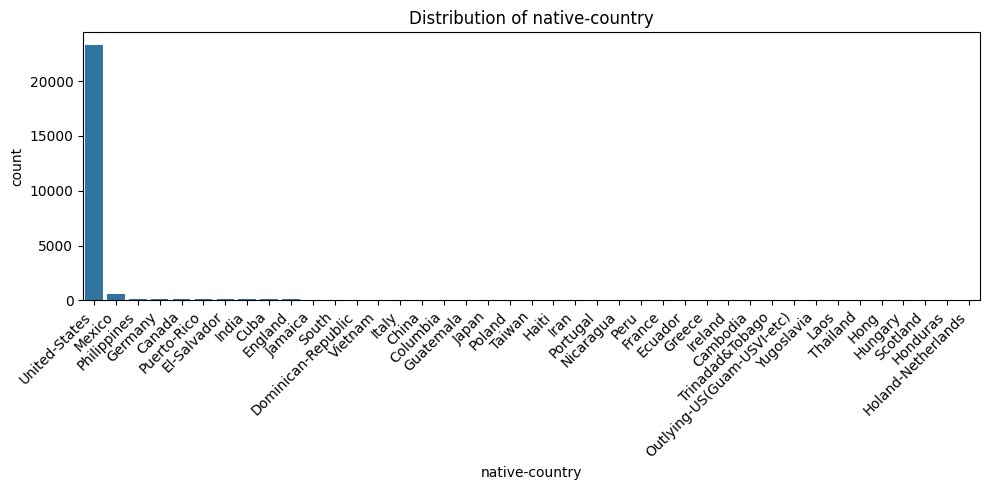

In [11]:


# Ploting distributions for columns with missing values
cols_to_plot = ['workclass', 'occupation', 'native-country']

for col in cols_to_plot:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [12]:
#Impute missing values in each column with its mode
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df_val.columns:
    df_val[col] = df_val[col].fillna(df_val[col].mode()[0])

In [13]:
#One Hot encoding variables

TEST_SIZE = 0.20
RANDOM_SEED = 35

categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']
numerical_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# features
X = df.drop(columns=['income'])
#target
y = df["income"].map({">50K": 1, "<=50K": 0})

#Train and test split
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler only on training numerical columns
X_train_num = scaler.fit_transform(X_train_df[numerical_cols])

# Transform test numerical columns
X_test_num = scaler.transform(X_test_df[numerical_cols])

# Replace the scaled columns in copies of the dataframes
X_train_proc = X_train_df.copy()
X_test_proc = X_test_df.copy()

X_train_proc[numerical_cols] = X_train_num
X_test_proc[numerical_cols] = X_test_num

# Final arrays ready for your models
X_train = X_train_proc.to_numpy()
X_test  = X_test_proc.to_numpy()

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (20838, 98), X_test shape: (5210, 98)
y_train shape: (20838,), y_test shape: (5210,)


Perceptron Model